In [2]:
import pandas as pd
import requests
import time

def fetch_race_data(start_year, end_year):
    print(f"Starting data collection from {start_year} to {end_year}...")
    all_races = []

    for year in range(start_year, end_year + 1):
        url = f"https://api.jolpi.ca/ergast/f1/{year}/results.json?limit=1000"

        try:
            response = requests.get(url)
            data = response.json()
            races = data['MRData']['RaceTable']['Races']

            for race in races:
                race_meta = {
                    'season': int(race['season']),
                    'round': int(race['round']),
                    'race_name': race['raceName'],
                    'circuit_id': race['Circuit']['circuitId'],
                    'date': race['date']
                }

                for result in race['Results']:
                    driver = race_meta.copy()
                    driver['driver_id'] = result['Driver']['driverId']
                    driver['grid'] = int(result['grid'])
                    try:
                        driver['position'] = int(result['position'])
                    except:
                        driver['position'] = None

                    all_races.append(driver)

            print(f"Season {year}: Success")
            time.sleep(1)

        except Exception as e:
            print(f"Season {year}: Failed ({e})")

    return pd.DataFrame(all_races)

df = fetch_race_data(2019, 2023)

df.to_csv('f1_race_data.csv', index=False)
print("DONE! File 'f1_race_data.csv' is ready to download.")

Starting data collection from 2019 to 2023...
Season 2019: Success
Season 2020: Success
Season 2021: Success
Season 2022: Success
Season 2023: Success
DONE! File 'f1_race_data.csv' is ready to download.


Loading datasets...
SUCCESS: Both Race Data and Weather Data loaded.


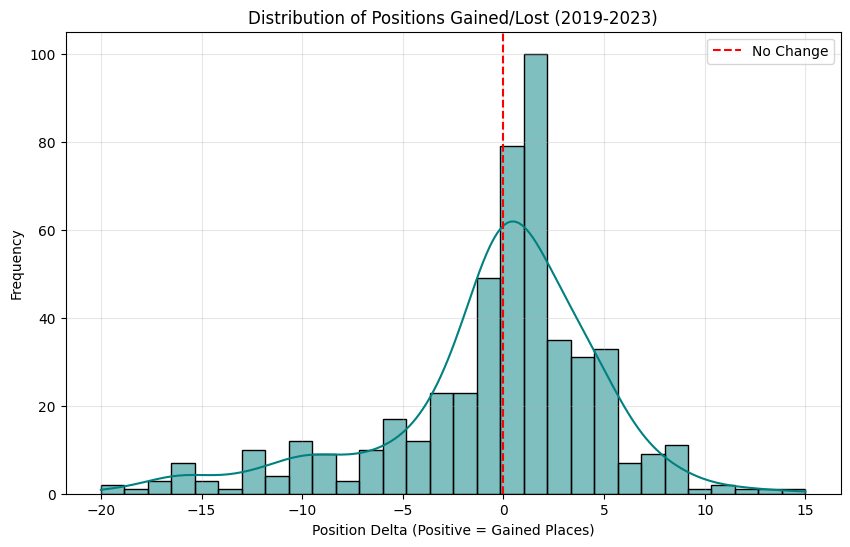


HYPOTHESIS TEST RESULTS
Null Hypothesis (H0): Top 3 starters gain the same number of positions as the rest.
Alternative Hypothesis (H1): Top 3 starters gain significantly fewer positions.

Average Positions Gained (Top 3): -3.92
Average Positions Gained (Rest):  0.27

T-Statistic: -5.8036
P-Value: 6.3267e-08

CONCLUSION: REJECT the Null Hypothesis.
There is a statistically significant difference in overtaking potential based on starting position.


In [3]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. LOAD THE DATA
print("Loading datasets...")
try:
    races = pd.read_csv('f1_race_data.csv')
    weather = pd.read_csv('weather.csv')
    print("SUCCESS: Both Race Data and Weather Data loaded.")
except FileNotFoundError:
    print("WARNING: One of the files is missing. Make sure both csv files are in the sidebar.")

# 2. FEATURE ENGINEERING (Preparing the data)
# We create a metric called 'position_delta'
# If you start P10 and finish P5, delta is +5 (Good)
# If you start P1 and finish P10, delta is -9 (Bad)
races['position_delta'] = races['grid'] - races['position']

# 3. VISUALIZATION (Exploratory Data Analysis)
# We will create a histogram to show how often drivers overtake others.
plt.figure(figsize=(10, 6))
sns.histplot(races['position_delta'].dropna(), bins=30, kde=True, color='teal')
plt.title('Distribution of Positions Gained/Lost (2019-2023)')
plt.xlabel('Position Delta (Positive = Gained Places)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. STATISTICAL HYPOTHESIS TEST
# Requirement: "conduct hypothesis tests on the data"
# Test: Do drivers starting in the "Top 3" have a harder time gaining positions
# compared to the rest of the field? (Since they have less traffic but nowhere to go but down).

print("\n" + "="*40)
print("HYPOTHESIS TEST RESULTS")
print("="*40)
print("Null Hypothesis (H0): Top 3 starters gain the same number of positions as the rest.")
print("Alternative Hypothesis (H1): Top 3 starters gain significantly fewer positions.")

# Split the data into two groups
group_top3 = races[races['grid'] <= 3]['position_delta'].dropna()
group_rest = races[races['grid'] > 3]['position_delta'].dropna()

# Perform T-Test
t_stat, p_val = stats.ttest_ind(group_top3, group_rest, equal_var=False)

print(f"\nAverage Positions Gained (Top 3): {group_top3.mean():.2f}")
print(f"Average Positions Gained (Rest):  {group_rest.mean():.2f}")
print(f"\nT-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("\nCONCLUSION: REJECT the Null Hypothesis.")
    print("There is a statistically significant difference in overtaking potential based on starting position.")
else:
    print("\nCONCLUSION: FAIL TO REJECT the Null Hypothesis.")